In [42]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
max_depth = 5

In [43]:
fields = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
data_wine = pd.read_csv(r"winequality-red.csv", sep=";")
print(len(data_wine.index))
data_wine.head()

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [44]:
data_cars = pd.read_csv("auto-mpg.csv")
data_cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [45]:
def prepare_data(which='Wine'):
    if which == "Wine":
        ## split in test and train set
        mask = np.random.rand(len(data_wine)) < 0.8
        X_train = data_wine[mask]
        X_test = data_wine[~mask]

        y_train = pd.Series(X_train['fixed acidity'])
        y_test = pd.Series(X_test['fixed acidity'])

        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        X_train = X_train.drop(columns=['fixed acidity'])
        X_train = X_train.reset_index(drop=True)

        X_test = X_test.drop(columns=['fixed acidity'])
        X_test = X_test.reset_index(drop=True)
        
        # print("X train:",len(X_train)," Y train:",len(y_train)," X Test: ",len(X_test)," Y test: ",len(y_test))

        return X_train,y_train,X_test,y_test
    
    elif which == "Cars":
        ## split in test and train set
        mask = np.random.rand(len(data_cars)) < 0.8
        X_train = data_cars[mask]
        X_test = data_cars[~mask]

        y_train = pd.Series(X_train['mpg'])
        y_test = pd.Series(X_test['mpg'])

        
        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)


        ## drop everything but horsepower and weight

        X_train = X_train.drop(columns=["cylinders", "displacement","acceleration","model year","origin","car name"])
        X_test = X_test.drop(columns=["cylinders", "displacement","acceleration","model year","origin","car name"])

        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)

        
        return X_train,y_train,X_test,y_test
    

def get_full_dataset(which="Wine"):
    if which == 'Wine':
        X = data_wine
        y = pd.Series(X['fixed acidity'])
        y = y.reset_index(drop=True)
        X = X.drop(columns=['fixed acidity'])
        X = X.reset_index(drop=True)

        return X,y
    
    elif which == 'Cars':
        X = data_cars
        y = pd.Series(X['mpg'])
        y = y.reset_index(drop=True)
        X = X.drop(columns=["cylinders", "displacement","acceleration","model","year","origin","car name"])
        X = X.reset_index(drop=True)

        return X,y


def split_into_folds(data,K=10):
    # print(len(data.index))
    return np.array_split(data,10)


def shuffle_df(data):
    return data.sample(frac=1).reset_index(drop=True)


### Fiecare nod va fi un dictionar de forma : {feature: f , separation_treshold: t, node_left (<= t) : nl, node_right (> t) : nr}

In [46]:
## Pandas Series
def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 

In [47]:

def transform_list(l):
    '''
    Transforma {10,12,13,44,50} in {11,12.5,28.5,47}
    '''
    tbr = []
    
    for i in range(len(l)-1):
        mean = (l[i] + l[i+1]) / 2
        tbr += [mean]

    return tbr

def find_best_rule(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        ## transform to couple means
        if type(thresholds[0]) == int or type(thresholds[0]) == float:
            thresholds = transform_list(thresholds)
        
        ## if list of strings should return each one

        # thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = rss(y_left, y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold, 'RSS': min_rss}

In [48]:
def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) <= 5:
        return {'prediction': np.mean(y_train), 'RSS':np.var(y_train)}
    
    
    rule = find_best_rule(X_train, y_train)
    
    left_ix = X_train[rule['feature']] < rule['threshold']
    
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

In [49]:
def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

In [50]:
def get_leaves(rules):
    leaves = []
    def get_leaves_inner(rules):
        nonlocal leaves
        ## daca nu e frunza
        if rules.get('prediction',None) == None:
            ## vizitez copii
            get_leaves_inner(rules['left'])
            get_leaves_inner(rules['right'])
        else:
            leaves += [rules]

    get_leaves_inner(rules)
    return leaves


def RSS_tree(rules):
    ## is leaf
    if rules.get('prediction',None) != None:
        return rules['RSS']

    leaves = get_leaves(rules)
    return np.mean([leaf['RSS'] for leaf in leaves])

def get_prune_prediction(node):
    leaves = get_leaves(node)
    return np.mean([leaf['prediction'] for leaf in leaves])

def C_alpha(rules,alpha=1):
    leaves = get_leaves(rules)
    return RSS_tree(rules) + alpha * len(leaves) 

In [51]:
def evaluate(X, y,rules):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    print(preds)
    return r2_score(preds, y)

In [52]:
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

def RMSE(y,t):
    return np.sqrt(mean_squared_error(y,t))


In [53]:
X_train,y_train,X_test,y_test = prepare_data()

y_train.head()

0     7.4
1     7.8
2    11.2
3     7.4
4     7.4
Name: fixed acidity, dtype: float64

In [54]:

X_train,y_train,X_test,y_test = prepare_data()
rules = split(X_train, y_train, 0, max_depth)

print(rules)
# print("\n\n")
# print(get_leaves(rules))
# print("\n\n")
# print(RSS_tree(rules))
# print("C ALPHA:",C_alpha(rules))

{'feature': 'citric acid', 'threshold': 0.365, 'RSS': 2388.517929644375, 'left': {'feature': 'pH', 'threshold': 3.3449999999999998, 'RSS': 681.7544834364144, 'left': {'feature': 'density', 'threshold': 0.9973700000000001, 'RSS': 262.5015728346457, 'left': {'feature': 'density', 'threshold': 0.9961249999999999, 'RSS': 141.0479744269453, 'left': {'feature': 'pH', 'threshold': 3.275, 'RSS': 54.047866120218586, 'left': {'prediction': 7.881666666666667, 'RSS': 0.6158305555555553}, 'right': {'prediction': 7.2262295081967185, 'RSS': 0.2802956194571352}}, 'right': {'feature': 'alcohol', 'threshold': 10.55, 'RSS': 62.63053030303031, 'left': {'prediction': 7.943181818181818, 'RSS': 0.35290805785123963}, 'right': {'prediction': 8.655555555555555, 'RSS': 0.5943209876543212}}}, 'right': {'feature': 'residual sugar', 'threshold': 3.6500000000000004, 'RSS': 87.2522077922078, 'left': {'feature': 'alcohol', 'threshold': 9.9, 'RSS': 42.578743961352664, 'left': {'prediction': 8.831884057971015, 'RSS': 0.

In [55]:

y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

results.head()

y_predicted_np = y_predicted.to_numpy()
y_test_np = y_test.to_numpy()

print("MSE is:",mean_squared_error(y_predicted_np,y_test_np))
print("RMSE is:",RMSE(y_predicted_np,y_test_np))

MSE is: 0.7870440075158852
RMSE is: 0.8871550076034543


In [56]:
def get_node_minimum_g(rules):

    min_g = 1e6
    min_t = None

    def get_node_minimum_g_inner(rules):
        nonlocal min_g
        nonlocal min_t

        ## leaf node
        if rules.get('prediction',None) != None:
            return
            
        g_score = (rules['RSS'] - RSS_tree(rules)) / (len(get_leaves(rules)) - 1)

        if g_score < min_g:
            min_g = g_score
            min_t = rules

        if rules.get('prediction',None) == None:
            get_node_minimum_g_inner(rules['left'])
            get_node_minimum_g_inner(rules['right'])

    get_node_minimum_g_inner(rules)
    return min_g,min_t


## o sa inlocuiasca subtree ce are ca parinte pe node cu node si predictia media predictiilor tuturor copiilor frunza
def eq_nodes(node1,node2):

    if node1.get('prediction',None) != None and node2.get('prediction',None) == None:
        return False

    if node2.get('prediction',None) != None and node1.get('prediction',None) == None:
        return False

    ## shouldnt enter here
    ## both are leaves
    
    if node1.get('prediction',None) != None and node2.get('prediction',None) != None:
        print("Shouldn't be here !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return None 

    return node1['feature'] == node2['feature'] and node1['threshold'] == node2['threshold'] and node1['RSS'] == node2['RSS']


## sper ca modifica dictionarul
def prune_node(rules,node):
    
    ## leaf
    if rules.get('prediction',None) != None:
        return

    left_child = rules.get('left',None)
    right_child = rules.get('right',None)

    if left_child != None:
        if eq_nodes(left_child,node):
            ## the left child is the node to be replaced
            new_RSS = RSS_tree(left_child)
            new_prediction = get_prune_prediction(left_child)
            rules['left'] = {'prediction': new_prediction,'RSS': new_RSS}
            return
        
        prune_node(left_child,node)

    if right_child != None:
        if eq_nodes(right_child,node):
            ## the right child is the node to be replaced
            new_RSS = RSS_tree(right_child)
            new_prediction = get_prune_prediction(right_child)
            rules['right'] = {'prediction': new_prediction,'RSS': new_RSS}
        

        prune_node(right_child,node)

## has only right and left children which each have 2 predictions    
## il las si sa aiba alte forme mai reduse
def is_in_final_form(rules):
    left_child = rules['left']
    right_child = rules['right']

    if left_child.get('prediction',None) != None and right_child.get('prediction',None) != None:
        return True

    # one_prediction_one_not_left = left_child.get('prediction',None) != None and (right_child['left'].get('prediction',None) != None and right_child['right'].get('prediction',None) != None)
    
    # one_prediction_one_not_right = right_child.get('prediction',None) != None and (left_child['left'].get('prediction',None) != None and left_child['right'].get('prediction',None) != None)
    
    # if one_prediction_one_not_left or one_prediction_one_not_right:
    #     return True 

    # ## aici iau key error left
    # cond_left = left_child['left'].get('prediction',None) != None and left_child['right'].get('prediction',None) != None 
    # cond_right = right_child['left'].get('prediction',None) != None and right_child['right'].get('prediction',None) != None 

    # return cond_left and cond_right

    return False

In [57]:

def pruning_algorithm(X_train,y_train,X_test,y_test,max_depth=5):
    stats = {}

    # print("Before splitting in prune")
    ## aici e problema
    rules = split(X_train, y_train, 0, max_depth)
    
    # print("Done splitting in prune")
    ## initial tree
    y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

    results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

    ## key: alpha, vals: [RMSE,RSS,tree]
    stats[0] = [RMSE(y_predicted.to_numpy(),y_test.to_numpy()),RSS_tree(rules),rules.copy()]

    # print("Completed first stats")

    while not is_in_final_form(rules):
        alpha,node = get_node_minimum_g(rules)
        # print("Got the minimum")
        prune_node(rules,node)
        # print("Pruned the node")

        ## now rules are pruned

        y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

        results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

        stats[alpha] = [RMSE(y_predicted.to_numpy(),y_test.to_numpy()),RSS_tree(rules),rules.copy()]

        # print("Updated stats in prune")
    

    return stats
        

def k_cross_validation(data,K=10,max_depth=5,type='Wine'):
    
    if type == 'Wine':
        to_be_dropped = ["fixed acidity"]
        to_predict = "fixed acidity"
    else:
        to_be_dropped = ["cylinders", "displacement","acceleration","model year","origin","car name"]
        to_predict = "mpg"
        
    stats = {}

    ## shuffle data
    # _data = shuffle_df(data)
    _data = data

    ## split into folds
    folds = split_into_folds(_data,K)

    for i in range(len(folds)):
        current_fold = folds[i]
        ## i set is for testing, the others for training
        # print("HERE")
        ## merge the rest of the df

        acc = pd.DataFrame()

        for j in range(len(folds)):
            if j == i:
                continue
            
            the_fold = folds[j]

            acc = pd.concat([acc,the_fold])

        acc = acc.reset_index(drop=True)

        # print("After concat")
        ## acc is the training set
        ## current_fold is the testing set

        training_raw = acc
        testing_raw = current_fold.reset_index(drop=True)

        y_train = pd.Series(training_raw[to_predict])
        y_test = pd.Series(testing_raw[to_predict])

        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        X_train = training_raw.drop(columns=to_be_dropped)
        X_train = X_train.reset_index(drop=True)

        X_test = testing_raw.drop(columns=to_be_dropped)
        X_test = X_test.reset_index(drop=True)

        ## I now have X_train,X_test,y_train,y_test

        stats_k = pruning_algorithm(X_train,y_train,X_test,y_test)

        # print("After pruning alg")

        stats[i] = stats_k

        # print("Done putting in stats")


    return stats
        

## WINE DATASET

In [58]:
X_train,y_train,X_test,y_test = prepare_data()
stats = pruning_algorithm(X_train,y_train,X_test,y_test)

In [59]:
k_fold_stats = k_cross_validation(data_wine)

In [60]:
best_alpha_per_fold = {}

for key,val in  k_fold_stats.items():
    # print("Fold:",key," with alphas:",list(val.keys()))
    best_alpha = 1e6
    min_RMSE = 1e6
    best_tree = None
    for item in val:
        # print("ALPHA:",item," RMSE:",val[item][0])
        if val[item][0] < min_RMSE:
            min_RMSE = val[item][0]
            best_alpha = item
            best_tree = val[item][2]
    best_alpha_per_fold[key] = (best_alpha,min_RMSE,best_tree)


best_tree = None
min_RMSE = 1e6
for key,val in best_alpha_per_fold.items():
    if val[1] < min_RMSE:
        min_RMSE = val[1]
        best_tree = val[2]

# print(best_alpha_per_fold)

## computea mean RMSE per alphas

RMSE_per_alpha = []
RMSE_per_alpha_computed = []
for i in range(100):
    RMSE_per_alpha.append([])

for key,val in k_fold_stats.items():
    count = 0
    for alpha in val:
        RMSE_per_alpha[count] += [val[alpha][0]]
        count += 1

# print(RMSE_per_alpha)

for errors in RMSE_per_alpha:
    if len(errors) > 0:
        RMSE_per_alpha_computed += [np.mean(errors)]

# print(RMSE_per_alpha_computed)
# print(np.argmin(np.array(RMSE_per_alpha_computed)))

X_train,y_train,X_test,y_test = prepare_data()
rules = split(X_train, y_train, 0, max_depth)


y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})


y_predicted_np = y_predicted.to_numpy()
y_test_np = y_test.to_numpy()

RMSE_initial = RMSE(y_predicted_np,y_test_np)

## predict for the best tree on the test dataset

# y_predicted = X_test.apply(predict,axis='columns',rules=best_tree.copy())

# results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

# y_predicted_np = y_predicted.to_numpy()
# y_test_np = y_test.to_numpy()

# RMSE_prunning = RMSE(y_predicted_np,y_test_np)


print("RMSE is:",RMSE_initial)
print("RMSE for the chosen alpha through cross validation is:",RMSE_per_alpha_computed[np.argmin(np.array(RMSE_per_alpha_computed))])
# print("RMSE for the chosen alpha through cross validation is @@@@:",RMSE_prunning)

RMSE is: 0.846221686321564
RMSE for the chosen alpha through cross validation is: 0.9635438270307205


##### Se observa ca RMSE e mai mare pe noul tree gasit, tocmai pentru ca cel initial facea overfit

### Values of alpha | Wine dataset

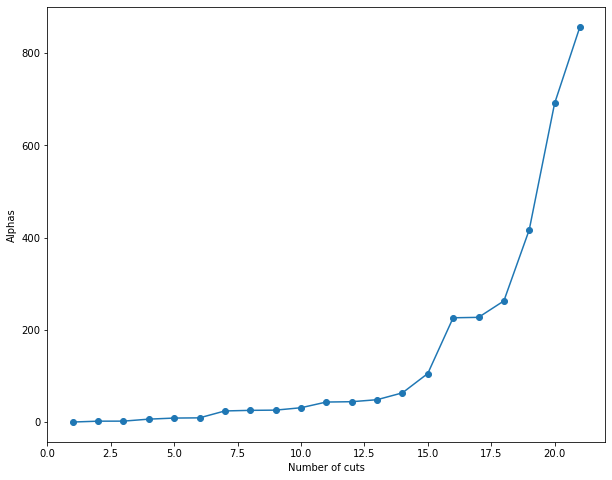

In [61]:

alphas = stats.keys()
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("Alphas")
plt.scatter([i+1 for i in range(len(alphas))],alphas)
plt.plot([i+1 for i in range(len(alphas))],alphas)
plt.show()



### RMSE vs alphas | Wine Dataset

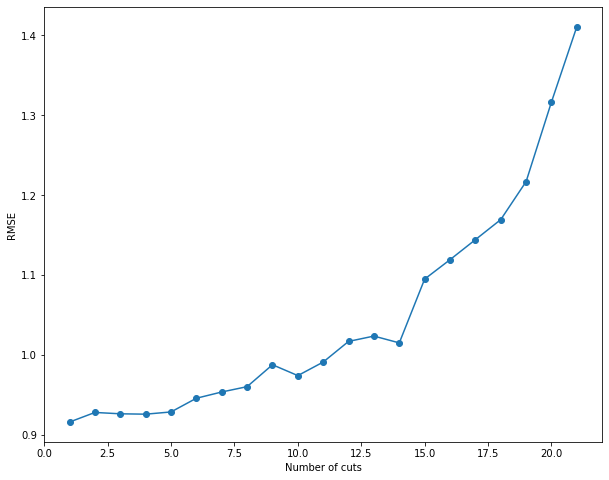

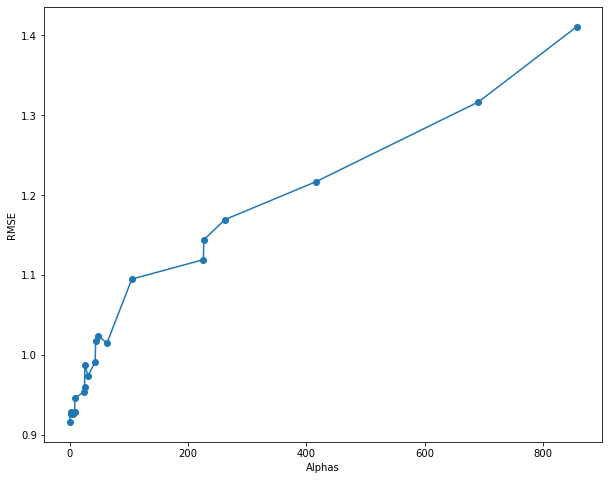

In [62]:

scores = [el[0] for el in stats.values()]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RMSE")
plt.scatter([i+1 for i in range(len(scores))],scores)
plt.plot([i+1 for i in range(len(scores))],scores)
plt.show()

## key: alpha 
## val[0] RMSE

scores = [el[0] for el in stats.values()]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Alphas")
plt.ylabel("RMSE")
plt.scatter(list(stats.keys()),scores)
plt.plot(list(stats.keys()),scores)
plt.show()


#### Se observa deci ca se pot face taieturi pentru a scadea din dimensiunea arborelui care nu cresc RMSE foarte mult ( sau chiar il scad )

### RSS per tree

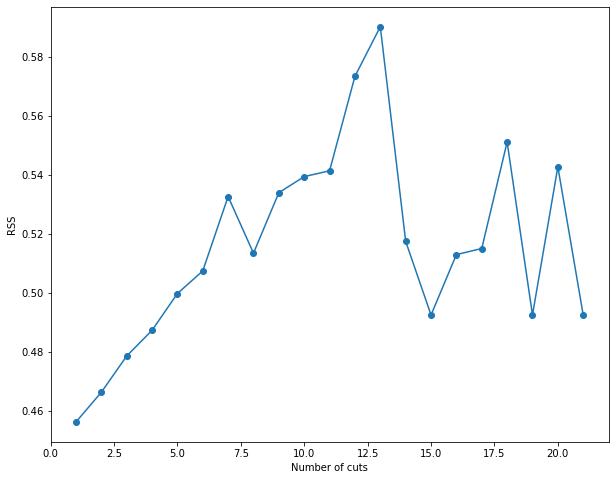

In [63]:
RSSs = [el[1] for el in stats.values()]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RSS")
plt.scatter([i+1 for i in range(len(RSSs))],RSSs)
plt.plot([i+1 for i in range(len(RSSs))],RSSs)
plt.show()

## Cars Dataset

In [64]:
k_fold_stats = k_cross_validation(data_cars,type="Cars")


In [65]:
X_train,y_train,X_test,y_test = prepare_data(which="Cars")
stats = pruning_algorithm(X_train,y_train,X_test,y_test)

In [66]:
best_alpha_per_fold = {}

for key,val in  k_fold_stats.items():
    # print("Fold:",key," with alphas:",list(val.keys()))
    best_alpha = 1e6
    min_RMSE = 1e6
    best_tree = None
    for item in val:
        # print("ALPHA:",item," RMSE:",val[item][0])
        if val[item][0] < min_RMSE:
            min_RMSE = val[item][0]
            best_alpha = item
            best_tree = val[item][2]
    best_alpha_per_fold[key] = (best_alpha,min_RMSE)


# print(best_alpha_per_fold)

## computea mean RMSE per alphas

RMSE_per_alpha = []
RMSE_per_alpha_computed = []
for i in range(100):
    RMSE_per_alpha.append([])

for key,val in k_fold_stats.items():
    count = 0
    for alpha in val:
        RMSE_per_alpha[count] += [val[alpha][0]]
        count += 1

# print(RMSE_per_alpha)

for errors in RMSE_per_alpha:
    if len(errors) > 0:
        RMSE_per_alpha_computed += [np.mean(errors)]

# print(RMSE_per_alpha_computed)
# print(np.argmin(np.array(RMSE_per_alpha_computed)))

X_train,y_train,X_test,y_test = prepare_data(which="Cars")
rules = split(X_train, y_train, 0, max_depth)


y_predicted = X_test.apply(predict,axis='columns',rules=rules.copy())

results = pd.DataFrame({"Predicted":y_predicted,"Real":y_test})

results.head()

y_predicted_np = y_predicted.to_numpy()
y_test_np = y_test.to_numpy()


print("RMSE is:",RMSE(y_predicted_np,y_test_np))
print("RMSE for the chosen alpha through cross validation is:",RMSE_per_alpha_computed[np.argmin(np.array(RMSE_per_alpha_computed))])

RMSE is: 0.39717813706477595
RMSE for the chosen alpha through cross validation is: 0.400495922918828


### Values of alpha | Car dataset

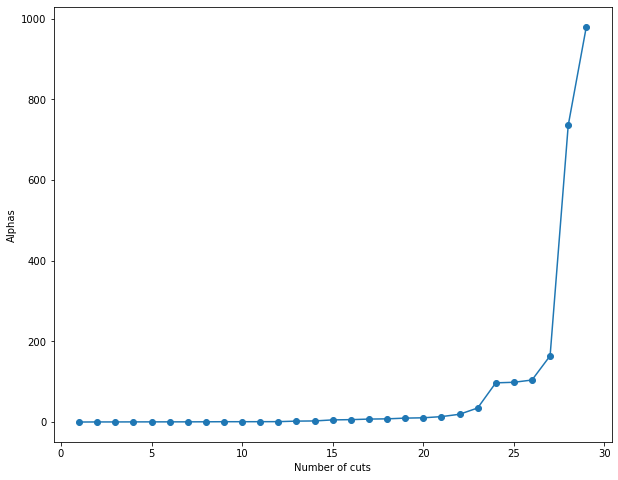

In [67]:

alphas = stats.keys()
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("Alphas")
plt.scatter([i+1 for i in range(len(alphas))],alphas)
plt.plot([i+1 for i in range(len(alphas))],alphas)
plt.show()



### RMSE vs number of cuts | Car Dataset

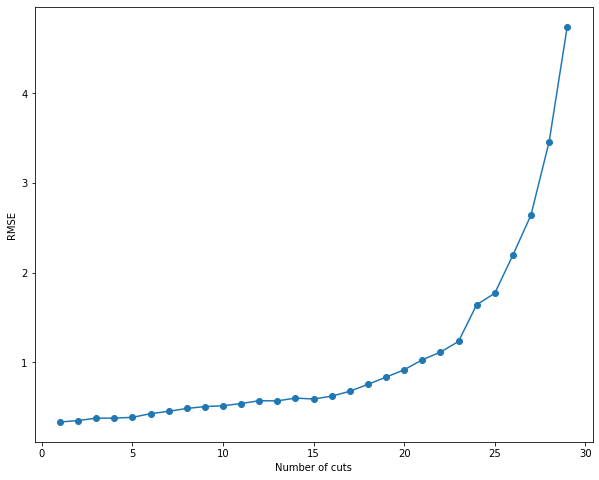

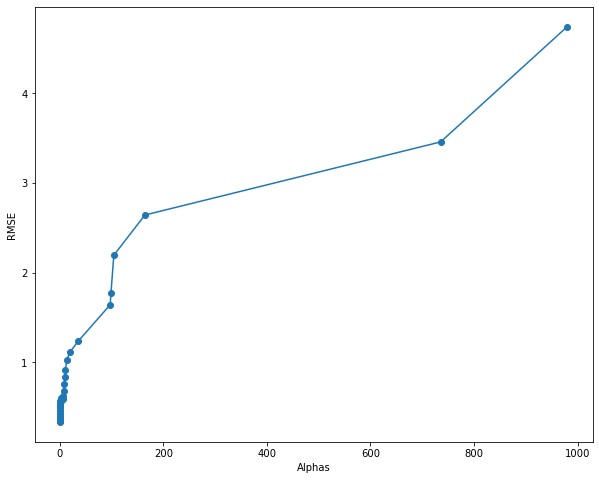

In [68]:
scores = [el[0] for el in stats.values()]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RMSE")
plt.scatter([i+1 for i in range(len(scores))],scores)
plt.plot([i+1 for i in range(len(scores))],scores)
plt.show()

## key: alpha 
## val[0] RMSE

scores = [el[0] for el in stats.values()]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Alphas")
plt.ylabel("RMSE")
plt.scatter(list(stats.keys()),scores)
plt.plot(list(stats.keys()),scores)
plt.show()


### RSS per tree

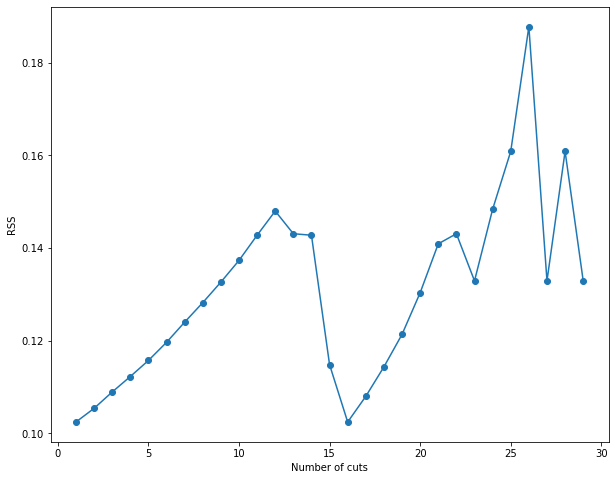

In [69]:
RSSs = [el[1] for el in stats.values()]

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Number of cuts")
plt.ylabel("RSS")
plt.scatter([i+1 for i in range(len(RSSs))],RSSs)
plt.plot([i+1 for i in range(len(RSSs))],RSSs)
plt.show()